In [3]:
# Importing modules for data science and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# NLP Libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.model_selection import GridSearchCV, cross_val_score
# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics import accuracy_score

## Data exploration

In [4]:
# Loading in the datasets
train = pd.read_csv("train.csv").fillna(' ')
test = pd.read_csv("test.csv").fillna(' ')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
# checking the distribution
train['sentiment'].value_counts()/train.shape[0]

 1    0.539225
 2    0.230103
 0    0.148745
-1    0.081927
Name: sentiment, dtype: float64

Text(0.5, 1.0, 'Distribution of target labels')

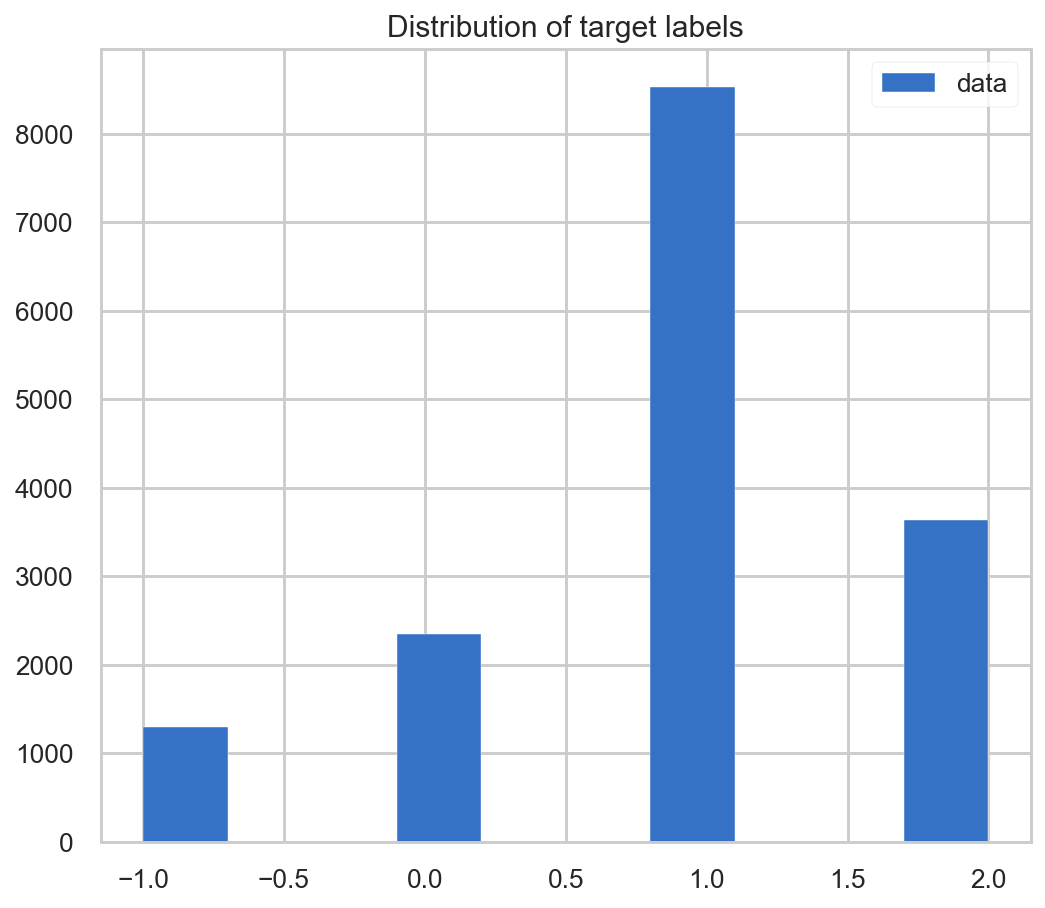

In [6]:
# Visualizing the distribution of the target 
plt.hist(train['sentiment'], label='data');
plt.legend();
plt.title('Distribution of target labels')

It is notable that there is an imbalance of classes in the daset  and these tend to be a common problem in machine learning classification where there are a disproportionate ratio of observations in each class. This is can cause problems as most algorithms are designed to maximize accuracy and reduce error. Therefore we ill address and take care of the class imbalance in our EDA

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(tweet for tweet in train.message)
print ("There are {} words in the combination of all tweets.".format(len(text)))

There are 1973801 words in the combination of all tweets.


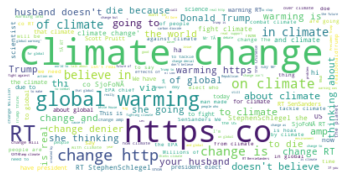

In [6]:
# Generating the word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Displaying the word cloud image:
# using matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word clouds are a simple visualization of data, in which words are shown in varying sizes depending on how often they appear. The kind of insight they provide even without much analysis being done helps in data normalization and in also what to expect as we dive deeper into data analysis. In our case, it is no surprise that both "climate change" and "global warming" as the biggest words in the could. Some other big words include "https" and "RT" which can be easily categorized as potential stopwords.

### Exploratory Data Analysis(EDA)

We begin with Database normalization which is the process of structuring a relational database in accordance with a series of normal forms in order to reduce data redundancy. This will aslo help improve data integrity as it entails organizing the attributes of a dataset to ensure that their dependencies are properly enforced by database integrity constraints.

Stemming and Lemmatization are Text Normalization techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.

A stemmer will return the stem of a word, which needn't be identical to the morphological root of the word. It usually sufficient that related words map to the same stem,even if the stem is not in itself a valid root, while in lemmatisation, it will return the dictionary form of a word, which must be a valid word.

In [7]:
# Testing the PorterStemmer 
stemmer = PorterStemmer()
print("The stemmed form of typing is: {}".format(stemmer.stem("typing")))
print("The stemmed form of types is: {}".format(stemmer.stem("types")))
print("The stemmed form of type is: {}".format(stemmer.stem("type")))

The stemmed form of typing is: type
The stemmed form of types is: type
The stemmed form of type is: type


In lemmatisation, the part of speech of a word should be first determined and the normalisation rules will be different for different part of speech, while the stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech.

In [8]:
# Testing Lemmatization
lemm = WordNetLemmatizer()
print("In  case of Lemmatization, typing is: {}".format(lemm.lemmatize("typing")))
print("In  case of Lemmatization, types is: {}".format(lemm.lemmatize("types")))
print("In  case of Lemmatization, type is: {}".format(lemm.lemmatize("type")))

In  case of Lemmatization, typing is: typing
In  case of Lemmatization, types is: type
In  case of Lemmatization, type is: type


### Data Preprocessing

This is an important step in the data mining process. In our case of classification, preprocessing data means; Data cleaning, Fill in missing values, smoothing noisy data and resolving any existing inconsistencies. Success in the steps will then make it possible and some-what easy for us to perform Data integration, Data transformation, Normalization and aggregation as well as Data reduction.

In [9]:
def data_preprocessor(df):
    '''
    For preprocessing we have regularized, transformed each upper case into lower case, tokenized,
    Normalized and remove stopwords. For normalization, we have used PorterStemmer. 
    Porter stemmer transforms a sentence from this "love loving loved" to this "love love love"
    
    '''
    stop_words = set(stopwords.words('english'))
    #stop_words.append(RT)
    stemmer = PorterStemmer()
    #lemm = WordNetLemmatizer()
    Tokenized_Doc=[]
    print("Preprocessing data.........\n")
    for data in df['message']:
        review = re.sub('[^a-zA-Z]', ' ', data)
        url = re.compile(r'https?://\S+|www\.\S+')
        review = url.sub(r'',review)
        html=re.compile(r'<.*?>')
        review = html.sub(r'',review)
        emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        review = emojis.sub(r'',review)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(review)
        #gen_tweets = [stemmer.stem(token) for token in tokens if not token in stop_words]
        gen_tweets = [lemm.lemmatize(token) for token in tokens if not token in stop_words]
        cleaned =' '.join(gen_tweets)
        Tokenized_Doc.append(gen_tweets)
        df['tweet tokens'] = pd.Series(Tokenized_Doc)
        #df.insert(loc=2, column='tweet tokens', value=Tokenized_Doc)
    return df

In [10]:
train_df = data_preprocessor(train)
train_df

Preprocessing data.........



,sentiment,message,tweetid,tweet tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,"[PolySciMajor, EPA, chief, think, carbon, diox..."
1,1,It's not like we lack evidence of anthropogeni...,126103,"[It, like, lack, evidence, anthropogenic, glob..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,"[RT, RawStory, Researchers, say, three, year, ..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,"[TodayinMaker, WIRED, pivotal, year, war, clim..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"[RT, SoyNovioDeTodas, It, racist, sexist, clim..."
...,...,...,...,...
15814,1,RT @ezlusztig: They took down the material on ...,22001,"[RT, ezlusztig, They, took, material, global, ..."
15815,2,RT @washingtonpost: How climate change could b...,17856,"[RT, washingtonpost, How, climate, change, cou..."
15816,0,notiven: RT: nytimesworld :What does Trump act...,384248,"[notiven, RT, nytimesworld, What, Trump, actua..."
15817,-1,RT @sara8smiles: Hey liberals the climate chan...,819732,"[RT, sara, smile, Hey, liberal, climate, chang..."


#### Data Normalization

In [11]:
X = train_df['tweet tokens']
y = train_df['sentiment']

In [2]:
data = train_df['tweet tokens']
corpus = [' '.join(i) for i in data] #create your corpus here

vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.toarray())

NameError: name 'train_df' is not defined

In [1]:
corpus

NameError: name 'corpus' is not defined

### Model Training

In [13]:
# SPLITTING THE DATA AND INITIALZING THE LOGISTIC REGRESSION CLASSIFIER
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scikit_log_reg = LogisticRegression(solver='liblinear',random_state=42) #, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(X_train, y_train)

In [14]:
# MODEL PREDICTIONS
y_pred = model.predict(X_test)
y_pred


array([1, 2, 1, ..., 1, 1, 1], dtype=int64)

In [15]:
# REVERSE CATEGORIES - DESCENDING ORDER OF IMPORTANCE
preds=[ item[::-1] for item in y_preds]

NameError: name 'y_preds' is not defined

In [ ]:
# MODEL PREDICTIONS: PROBABILITIES
probs = model.predict_proba(X_test)
probs

In [ ]:
# GET TOP K PREDICTIONS BY PROB - note these are just index
best_n = np.argsort(probs, axis=1)[:,-5:]
best_n

In [ ]:
# GET CATEGORY OF PREDICTIONS
preds_prob=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
preds_prob

### Model Evaluation

We use a Confusion Matrix which is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values.

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))

This is then fllowed by a Classification report which is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. 
More specifically, True Positives, False Positives, True negatives and False Negatives are used to predict the metrics of a classification report as shown below.

In [ ]:
print(metrics.classification_report(y_test, y_pred))

### Predicting on the test.csv

In [ ]:
# Data cleaning
test_df = data_preprocessor(test)

In [ ]:
# Data normalization
data2 = test_df['tweet tokens']
corpus = [' '.join(i) for i in data2] #create your corpus here

tests = vectorizer.transform(corpus, copy=True)
#print(vectorizer.get_feature_names())
#print(tests.toarray())

In [ ]:
# Using the same model to do the predictions
pred = model.predict(tests)
predictions = pred[:]
predictions